In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

*Always remember to install fastai and fastbook...*

In [3]:
# installing/upgrading fastai2 
!pip install --upgrade fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.2/232.2 kB 1.9 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.13
    Uninstalling fastai-2.7.13:
      Successfully uninstalled fastai-2.7.13


from https://colab.research.google.com/github/fastai/fastbook/blob/master/11_midlevel_data.ipynb

In [5]:
# installing/upgrading fastai2 
!pip install --upgrade fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 4.1 MB/s eta 0:00:00a 0:00:01


In [6]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [8]:
#hide
from fastbook import *
from IPython.display import display,HTML

**Going Deeper into fastai's Layered API**

In [9]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

In [10]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

**Transforms**

In [11]:
files = get_text_files(path, folders = ['train', 'test'])
txts = L(o.open().read() for o in files[:2000])

In [12]:
tok = Tokenizer.from_folder(path)
tok.setup(txts)
toks = txts.map(tok)
toks[0]

(#419) ['xxbos','xxmaj','this','is','an','oft','-','used','line',','...]

In [13]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

TensorText([   2,    8,   20,   16,   54, 5679,   25,  386,  337,   11])

In [14]:
nums_dec = num.decode(nums[0][:10]); nums_dec

(#10) ['xxbos','xxmaj','this','is','an','oft','-','used','line',',']

In [15]:
tok((txts[0], txts[1]))

((#419) ['xxbos','xxmaj','this','is','an','oft','-','used','line',','...],
 (#334) ['xxbos','xxmaj','let','me','first','start','out','by','saying','1'...])

In [16]:
def f(x:int): return x+1
tfm = Transform(f)
tfm(2),tfm(2.0)

(3, 2.0)

In [17]:
@Transform
def f(x:int): return x+1
f(2),f(2.0)

(3, 2.0)

In [18]:
class NormalizeMean(Transform):
    def setups(self, items): self.mean = sum(items)/len(items)
    def encodes(self, x): return x-self.mean
    def decodes(self, x): return x+self.mean

In [19]:
tfm = NormalizeMean()
tfm.setup([1,2,3,4,5])
start = 2
y = tfm(start)
z = tfm.decode(y)
tfm.mean,y,z

(3.0, -1.0, 2.0)

In [20]:
tfms = Pipeline([tok, num])
t = tfms(txts[0]); t[:20]

TensorText([   2,    8,   20,   16,   54, 5679,   25,  386,  337,   11,   28,   17,   81, 3744,   74,   20,   26,   70,   22,   60])

In [21]:
tfms.decode(t)[:100]

'xxbos xxmaj this is an oft - used line , but it really sums up this movie … " if this is the current'

**TfmdLists and Datasets: Transformed Collections**

In [22]:
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize])

In [23]:
t = tls[0]; t[:20]

TensorText([    2,     8,    20,    16,    49, 11298,    24,   348,   369,    11,    31,    17,    85,  5608,    73,    20,    30,    76,    22,    63])

In [24]:
tls.decode(t)[:100]

'xxbos xxmaj this is an oft - used line , but it really sums up this movie … " if this is the current'

In [25]:
tls.show(t)

xxbos xxmaj this is an oft - used line , but it really sums up this movie … " if this is the current state of gay cinema , then we 're in real trouble " . i saw this film at xxup siff because of the high imdb rating ( 7.6 ) and if there was ever a case of vote stacking on imdb , then this is it . xxmaj just watch the number fall over the release weeks of the film . 

 xxmaj easy plot … boy finds out his high school ex ( boyfriend ) is getting married to a female friend of theirs so he goes back to his old hometown ( still carrying a 10 year old torch ) to see what happened . 

 xxmaj first off , i liked " latter xxmaj days " , the director 's last feature , despite its cookie cutter characters and plot contrivances , but you 're supposed to become a better director with each subsequent release . i do n't know how you get horrible supporting performances out of so many xxup tv veterans ( robert xxmaj foxworth , xxmaj joanna xxmaj cassidy , xxmaj tori xxmaj spelling ) , but somehow he ma

In [26]:
cut = int(len(files)*0.8)
splits = [list(range(cut)), list(range(cut,len(files)))]
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize], 
                splits=splits)

In [27]:
tls.valid[0][:20]

TensorText([  2,   8,   9,   8, 947,   8, 682,  26,   8,  65,  33,  86,  16,  65,  33,  98,  10,   8,  38,  85])

In [28]:
lbls = files.map(parent_label)
lbls

(#50000) ['neg','neg','neg','neg','neg','neg','neg','neg','neg','neg'...]

In [29]:
cat = Categorize()
cat.setup(lbls)
cat.vocab, cat(lbls[0])

(['neg', 'pos'], TensorCategory(0))

In [30]:
tls_y = TfmdLists(files, [parent_label, Categorize()])
tls_y[0]

TensorCategory(0)

In [31]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms])
x,y = dsets[0]
x[:20],y

(TensorText([    2,     8,    20,    16,    49, 11298,    24,   348,   369,    11,    31,    17,    85,  5608,    73,    20,    30,    76,    22,    63]),
 TensorCategory(0))

In [32]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits)
x,y = dsets.valid[0]
x[:20],y

(TensorText([  2,   8,   9,   8, 947,   8, 682,  26,   8,  65,  33,  86,  16,  65,  33,  98,  10,   8,  38,  85]),
 TensorCategory(1))

In [33]:
t = dsets.valid[0]
dsets.decode(t)

("xxbos xxmaj the xxmaj write xxmaj word \n\n xxmaj what you see is what you get . xxmaj not really ! xxmaj what xxmaj madhur xxmaj bhandarkar 's brave and brilliant ' page 3 ' does is destroy the myth attached to the glam and xxunk that colour the pages of our newspapers and whose xxunk party habits ) we follow with such maniacal fervour which only our intrinsic voyeuristic streak can explain . \n\n xxmaj the page 3 phenomenon is as deplorable as it is enigmatic . xxmaj how exactly did it gain such control over the printed word and when did it start to encroach into the front page is subject for another debate . xxmaj bhandarkar cleverly avoids that . xxmaj he is concerned only with the mechanisms of this grotesque existence . xxmaj and in doing that , he pieces together the various elements of this way of life . xxmaj like xxmaj robert xxmaj xxunk xxmaj i 'm not comparing xxmaj bhandarkar to xxmaj altman 's genius ) , xxmaj bhandarkar uses myriad characters to further his motive . xx

In [35]:
dls = dsets.dataloaders(bs=64, before_batch=pad_input)

In [36]:
tfms = [[Tokenizer.from_folder(path), Numericalize], [parent_label, Categorize]]
files = get_text_files(path, folders = ['train', 'test'])
splits = GrandparentSplitter(valid_name='test')(files)
dsets = Datasets(files, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input)

**Applying the Mid-Level Data API: SiamesePair**

In [37]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

In [39]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), 
                          title=same_breed, ctx=ctx)

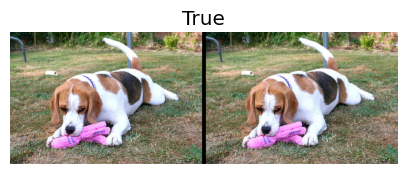

In [40]:
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show();

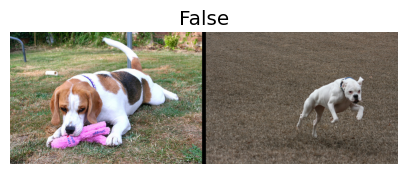

In [41]:
img1 = PILImage.create(files[1])
s1 = SiameseImage(img, img1, False)
s1.show();

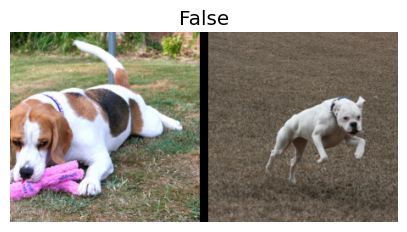

In [42]:
s2 = Resize(224)(s1)
s2.show();

In [43]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

In [44]:
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) 
                          for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: 
            cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same

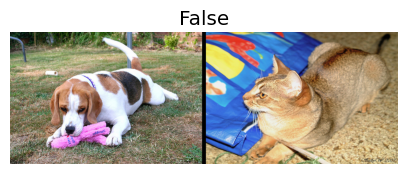

In [45]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tfm(files[0]).show();

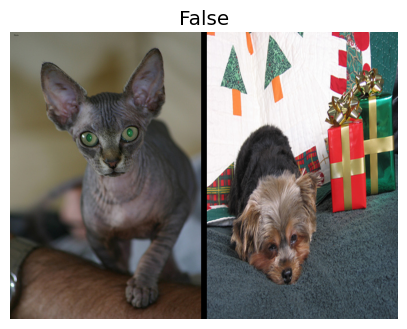

In [46]:
tls = TfmdLists(files, tfm, splits=splits)
show_at(tls.valid, 0);

In [47]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])